In [125]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime
from typing import Union
import logging
import sys

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)


def get_test_data():

  test_data = """
  with users as (
  SELECT DISTINCT
                entity_id,
                test_id,
                variant,
                count(distinct perseus_client_id) users
    FROM `fulfillment-dwh-production.curated_data_shared.dps_test_cvr_treatment`
    WHERE true
      AND created_date >= "2022-01-01" and created_date < "2025-01-01"
      AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
    GROUP BY entity_id, test_id, variant
  ), 
  orders as (
    SELECT
      o.entity_id,
      o.test_id,
      o.test_variant variant,
      c.users users_control,
      v.users users_variation,
      count(distinct o.platform_order_code) raw_orders,
      count(distinct o.platform_order_code) * (c.users / v.users) orders,    
      sum(o.fully_loaded_gross_profit_eur * c.users / v.users) flgp_eur,
      sum(o.fully_loaded_gross_profit_eur) / count(distinct o.platform_order_code) flgpo_eur
    FROM `fulfillment-dwh-production.curated_data_shared.dps_test_orders` o
    LEFT JOIN users c ON o.entity_id = c.entity_id AND c.test_id = o.test_id AND c.variant = 'Control'
    LEFT JOIN users v ON o.entity_id = v.entity_id AND v.test_id = o.test_id AND v.variant = o.test_variant
    WHERE true
      AND o.created_date >= "2022-01-01" and o.created_date < "2025-01-01"
      AND o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
      AND is_sent = True
      AND is_own_delivery = True
      AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
    GROUP BY o.entity_id, o.test_id, o.test_variant,c.users, v.users
    HAVING c.users > 0 AND v.users > 0
    ORDER BY o.test_id, o.entity_id
  ),  
  stats as (
    SELECT
      c.entity_id,
      c.test_id,
      v.variant variation,
      c.users_control,
      v.users_variation,
      c.raw_orders raw_orders_control,
      v.raw_orders raw_orders_variation,
      c.orders orders_control,
      v.orders orders_variation,
      c.flgpo_eur flgpo_eur_control,
      v.flgpo_eur flgpo_eur_variation,
      c.flgp_eur flgp_eur_control,
      v.flgp_eur flgp_eur_variation,
      c.flgp_eur / c.users_control flgpu_control,
      v.flgp_eur / v.users_control flgpu_variation,
      v.orders - c.orders incremental_orders,
      v.flgp_eur - c.flgp_eur incremental_profit,
      (v.orders - c.orders) / NULLIF(c.orders, null) order_change_pct, 
      (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) profit_change_pct, 
      c.raw_orders / NULLIF(c.users_control, 0) orders_per_user_control,
      v.raw_orders / NULLIF(v.users_variation, 0) orders_per_user_variation, 
      RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.orders - c.orders) / NULLIF(c.orders, 0) DESC) AS order_rank,
      RANK() OVER (PARTITION BY c.entity_id, c.test_id ORDER BY (v.flgp_eur - c.flgp_eur) / NULLIF(c.flgp_eur, 0) DESC) AS profit_rank,
      case 
        when c.orders = v.orders and c.flgpo_eur = v.flgpo_eur
        then 'Neutral'
        when c.orders <= v.orders and ((c.flgpo_eur <= v.flgpo_eur) or (c.flgp_eur < v.flgp_eur))
        then 'Win-Win'
        when c.orders >= v.orders and c.flgp_eur >= v.flgp_eur
        then 'Lose-Lose'
        when c.orders > v.orders and c.flgp_eur < v.flgp_eur
        then 'MPOL - Profit at a Cost'
        when c.orders < v.orders and c.flgp_eur > v.flgp_eur
        then 'CPiO - Growth at a Cost'
      end scenario  
    FROM orders c
    LEFT JOIN orders v ON c.entity_id = v.entity_id AND c.test_id = v.test_id AND v.variant <> 'Control'
    WHERE c.variant = 'Control'
      AND c.orders > 0
      AND v.orders > 0
  ),
  winning_variants AS (
    SELECT
      *,
      ROW_NUMBER() OVER (
      PARTITION BY entity_id, test_id 
      ORDER BY 
          CASE WHEN scenario = 'Win-Win' THEN 1 ELSE 2 END, -- Order 'Win-Win' rows first
          order_rank ASC,
          profit_rank ASC
      ) AS final_rank
    FROM stats
  ),
  experiments AS (
    SELECT distinct 
      entity_id,
      country_code,
      test_id,
      test_name,
      hypothesis,
      objective,
      cast(date_trunc(test_start_date, MONTH) as date) start_month,
      cast(date_trunc(test_start_date, ISOWEEK) as date) start_week,
      cast(date_trunc(test_end_date, MONTH) as date) end_month,
      cast(date_trunc(test_end_date, ISOWEEK) as date) end_week,
      test_start_date,
      test_end_date,
      TIMESTAMP_DIFF(IFNULL(test_end_date, CURRENT_TIMESTAMP() - INTERVAL 1 DAY), test_start_date, DAY) test_length,
      is_active,
      variation_share
      --case when test_id = 86 and entity_id = 'PY_SV' then 1 else 0 end check
    FROM `fulfillment-dwh-production.curated_data_shared.dps_experiment_setups`
    WHERE NOT misconfigured
      AND entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HS_SA', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
      AND is_already_executed
      AND experiment_type = 'AB'
      AND test_start_date >= '2022-01-01' and test_start_date < "2025-01-01"
      AND ('restaurant' IN UNNEST(test_vertical_parents) OR 'Restaurant' IN UNNEST(test_vertical_parents) 
      OR  'restaurants' IN UNNEST(test_vertical_parents))
      AND test_name NOT LIKE '%FDNC%'
  )
  SELECT
    c.region,
    c.brand_name,
    c.country_name,
    e.*,
    w.* except(entity_id, test_id),
    w.orders_per_user_variation -  w.orders_per_user_control orders_per_user_incremental,
    w.flgpu_variation -  w.flgpu_control flgp_per_user_incremental
  FROM experiments e
  INNER JOIN winning_variants w ON e.entity_id = w.entity_id AND e.test_id = w.test_id 
  left join 
            (
              select DISTINCT
                      p.entity_id,
                      c.country_name,
                      c.region,
                      p.brand_name
              from `fulfillment-dwh-production.cl.countries` c
              left join unnest(c.platforms) p
            ) c on c.entity_id = e.entity_id
  --where check = 0
  ORDER BY e.entity_id, e.test_id
  """

  return test_data


def get_actuals():

  seasonal = """
  with session as (
  SELECT   ss.entity_id
          ,EXTRACT(YEAR FROM created_date) AS Year
          ,DATE_TRUNC(created_date, MONTH) Month
          ,count(distinct sessions.perseus_client_id) total_users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
  where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
  and created_date >= '2023-01-01' and created_date <= '2023-05-31'
  group by 1,2,3
  UNION ALL
  SELECT   ss.entity_id
          ,EXTRACT(YEAR FROM created_date) AS Year
          ,DATE_TRUNC(created_date, MONTH) Month
          ,count(distinct sessions.perseus_client_id) total_users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
  where entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
  and created_date >= '2023-06-01' and created_date < "2024-12-01"
  group by 1,2,3
  ), 
  orders as (
  SELECT   o.entity_id
          ,EXTRACT(YEAR FROM created_date_local) AS Year
          ,DATE_TRUNC(created_date_local, MONTH) Month
          ,sum(fully_loaded_gross_profit_eur) fully_loaded_gross_profit_eur
          ,count(distinct platform_order_code) total_orders
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
  where o.entity_id in ('AP_PA', 'PY_AR', 'PY_BO', 'PY_CL', 'PY_CR', 'PY_DO', 'PY_EC', 'PY_GT', 'PY_HN', 'PY_NI', 'PY_PE', 'PY_PY', 'PY_SV', 'PY_UY', 'PY_VE', 'FP_BD', 'FP_HK', 'FP_KH', 'FP_LA', 'FP_MM', 'FP_MY', 'FP_PH', 'FP_PK', 'FP_SG', 'FP_TH', 'FP_TW', 'DJ_CZ', 'FO_NO', 'FP_SK', 'MJM_AT', 'NP_HU', 'OP_SE', 'PO_FI', 'FY_CY', 'EF_GR', 'HF_EG', 'TB_AE', 'TB_BH', 'TB_IQ', 'TB_JO', 'TB_KW', 'TB_OM', 'TB_QA', 'YS_TR')
  AND is_sent = True
  AND is_own_delivery = True
  AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
  AND created_date >= '2022-12-31' and created_date <= '2024-12-02'
  AND created_date_local >= '2023-01-01' and created_date_local < "2024-12-01"
  group by 1,2,3
  )
  select   s.entity_id
          ,s.YEAR
          ,s.Month
          ,s.total_users
          ,o.fully_loaded_gross_profit_eur
          ,o.total_orders
          ,fully_loaded_gross_profit_eur / total_users flgpu_eur
          ,total_orders / total_users orders_per_user
  from session s
  left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
  """

  return seasonal


def get_significant_data():
  
  significance = """
  WITH filtered_data AS (
      SELECT 
          country_code
          ,test_name
          ,group_b variation
          ,max(case when kpi_label = 'orders_per_user' then mean_a else null end) AS orders_per_user_control
          ,max(case when kpi_label = 'orders_per_user' then incremental else null end) AS incremental_orders_per_user
          ,max(case when kpi_label = 'orders_per_user' then significance else null end) AS significance_orders_per_user
          ,max(case when kpi_label = 'orders_per_user' then rn else null end) AS rn_orders_per_user
          ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then mean_a else null end) AS profit_per_user_control
          ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then incremental else null end) AS incremental_profit_per_user
          ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then significance else null end) AS significance_profit_per_user
          ,max(case when kpi_label in ('fully_loaded_gross_profit_local_per_user', 'profit_local_per_user') then rn else null end) AS rn_profit_per_user
          ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then mean_a else null end) AS fully_loaded_gross_profit_local_per_user_control
          ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then incremental else null end) AS incremental_fully_loaded_gross_profit_local_per_user
          ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then significance else null end) AS significance_fully_loaded_gross_profit_local_per_user
          ,max(case when kpi_label = 'fully_loaded_gross_profit_local_per_user' then rn else null end) AS rn_fully_loaded_gross_profit_local_per_user
      FROM (
          SELECT 
              country_code
              ,test_name
              ,kpi_label
              ,mean_a
              ,group_b
              ,LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) AS min_p_value
              ,CASE 
                  WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                  ELSE 0 
              END AS significance
              ,(mean_b - mean_a) AS incremental
              ,ROW_NUMBER() OVER (
                  PARTITION BY test_name, kpi_label
                  ORDER BY 
                      CASE 
                          WHEN LEAST(p_value, corrected_p_value, cuped_p_value, corrected_cuped_p_value) <= 0.05 THEN 1 
                          ELSE 0 
                      END DESC,
                      (mean_b - mean_a) DESC
              ) AS rn
          FROM 
              `fulfillment-dwh-production.rl.dps_ab_test_significance_dataset_temp`
          WHERE processing_status = 'success'
              AND group_a = 'Control'
              AND group_b != 'Control'
              AND kpi_label IN ('orders_per_user', 'fully_loaded_gross_profit_local_per_user', 'profit_local_per_user')
              AND label = 'All'
              AND test_name NOT LIKE '%FDNC%'
      )
      GROUP BY country_code, test_name, group_b
  ),
  ranked_data AS (
      SELECT *,
          ROW_NUMBER() OVER (
          PARTITION BY country_code, test_name
          ORDER BY 
              CASE 
                  WHEN significance_orders_per_user = 1 AND significance_profit_per_user = 1 THEN 1
                  WHEN significance_orders_per_user = 1 THEN 3
                  WHEN significance_profit_per_user = 1 THEN 2
                  WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN 4
                  ELSE 5
              END ASC,
              CASE 
                  WHEN incremental_orders_per_user > 0 AND incremental_profit_per_user > 0 THEN NULL
                  ELSE incremental_orders_per_user
              END DESC,
              significance_orders_per_user DESC
      ) AS rank
      FROM filtered_data
  )
  SELECT  *
  FROM ranked_data
  --where rank = 1
  """

  return significance


def get_hungerstation_actuals():

  hungersta_seasonal = """
  with session as (
  SELECT   ss.entity_id
          ,EXTRACT(YEAR FROM created_date) AS Year
          ,DATE_TRUNC(created_date, MONTH) Month
          ,count(distinct sessions.perseus_client_id) total_users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_ga_sessions` ss
  where entity_id = 'HS_SA'
  and created_date >= '2023-01-01' and created_date <= '2023-05-31'
  group by 1,2,3
  UNION ALL
  SELECT   ss.entity_id
          ,EXTRACT(YEAR FROM created_date) AS Year
          ,DATE_TRUNC(created_date, MONTH) Month
          ,count(distinct sessions.perseus_client_id) total_users
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_perseus_sessions` ss
  where entity_id ='HS_SA'
  and created_date >= '2023-06-01' and created_date < "2024-12-01"
  group by 1,2,3
  ),
  orders as (
  select entity_id,
        Year,
        Month,
        flgp_eur + (rdf_adjusted_df - delivery_fee_eur) AS Adjusted_Flgp_eur,
        flgp_eur non_adjusted_flgp,
        total_orders
  from (
  SELECT 
      o.entity_id,
      EXTRACT(YEAR FROM created_date_local) AS Year,
      DATE_TRUNC(created_date_local, MONTH) Month,
      count(distinct o.platform_order_code) total_orders,
      SUM(rdf.OD_delivery_fee / ex.exchange_rate) AS converted_OD_delivery_fee,
      SUM(
          COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
      ) AS rdf_adjusted_df,
      SUM(o.delivery_fee_eur) delivery_fee_eur,
      SUM(o.revenue_eur) AS total_revenue,
      SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) gross_profit_eur,
      SUM(o.revenue_eur) - SUM(o.delivery_costs_eur) - SUM(o.discount_dh_eur) - SUM(o.voucher_dh_eur) AS flgp_manual_eur,
      SUM(o.delivery_costs_eur) + SUM(o.discount_dh_eur) + SUM(o.voucher_dh_eur) total_costs,
      SUM(o.fully_loaded_gross_profit_eur) AS flgp_eur,
      (
          SUM(o.joker_vendor_fee_eur)
          + SUM(commission_eur)
          + SUM(o.priority_fee_eur * (1 - o.vat_rate))
          + SUM(o.service_fee_eur * (1 - o.vat_rate))
          + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
          + SUM(o.front_margin_eur)
          + SUM(o.delivery_fee_eur * (1 - o.vat_rate))
      ) AS manual_revenue,
      (
          SUM(o.joker_vendor_fee_eur)
          + SUM(commission_eur)
          + SUM(o.priority_fee_eur * (1 - o.vat_rate))
          + SUM(o.service_fee_eur * (1 - o.vat_rate))
          + SUM(o.mov_customer_fee_eur * (1 - o.vat_rate))
          + SUM(o.front_margin_eur)
          + SUM(
          COALESCE((rdf.OD_delivery_fee + 4.7) / ex.exchange_rate, o.delivery_fee_eur)
          * (1 - o.vat_rate))
      ) AS adjusted_manual_revenue
  --     o.created_date,
  --     o.platform_order_code,
  --     o.delivery_fee_eur,
  --     rdf.OD_delivery_fee,
  --     ex.exchange_rate,
  --     o.vat_rate
  FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
  left JOIN `logistics-data-storage-staging.long_term_pricing.hs_sa_rdf_orders` rdf ON CAST(rdf.platform_order_code AS STRING) = o.platform_order_code
  LEFT JOIN (
      SELECT 
          date,
          currency_code, 
          max(exchange_rate) exchange_rate
      FROM 
          `fulfillment-dwh-production.cl._currency_exchange`
      WHERE 
          country_code = 'sa' 
      GROUP BY 1,2
  ) ex ON ex.currency_code = o.currency_code and ex.date = o.created_date
  WHERE o.entity_id = 'HS_SA'
        AND is_sent = True
        AND is_own_delivery = True
        AND created_date >= '2022-12-31' and created_date < "2024-12-02"
        AND created_date_local >= '2023-01-01' and created_date_local < "2024-12-01"
        AND vendor_id in (
                  select distinct vendor_id
                  from (
                  SELECT 
                      vendor_id,
                      COALESCE(
                      FIRST_VALUE(vendor_vertical_parent IGNORE NULLS) OVER (
                          PARTITION BY vendor_id
                          ORDER BY created_date DESC
                      ),
                      FIRST_VALUE(vertical_type IGNORE NULLS) OVER (
                          PARTITION BY vendor_id
                          ORDER BY created_date DESC
                      )
                  ) AS selected_vertical
              FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders`
              WHERE entity_id = 'HS_SA'
              QUALIFY ROW_NUMBER() OVER (PARTITION BY vendor_id ORDER BY created_date DESC) = 1
              )
              where selected_vertical in('Restaurant','restaurant','restaurants','Restaurants')
  ) 
  group by 1,2,3
  ))
  select   s.entity_id
          ,s.YEAR
          ,s.Month
          ,s.total_users
          ,o.Adjusted_Flgp_eur fully_loaded_gross_profit_eur
          ,o.total_orders
          ,o.Adjusted_Flgp_eur / s.total_users flgpu_eur
          ,o.total_orders / s.total_users orders_per_user
          ,o.non_adjusted_flgp
  from session s
  left join orders o on o.entity_id = s.entity_id and o.Month = s.Month
  """

  return hungersta_seasonal

In [126]:
def combine_actuals():
    
    """
    Query to combine actuals for hungerstation and other entities part of DPS. Hungerstation data is extracted separately to 
    correct for RDF orders
    """

    # Fetch dataframes from queries
    tmp = client.query(get_actuals()).to_dataframe()
    tmp2 = client.query(get_hungerstation_actuals()).to_dataframe()

    # Concatenate dataframes
    combined_df = pd.concat([tmp, tmp2], ignore_index=True)

    return combined_df


def filter_merged_df(df1, df2):

    """
    Query to filter the dataframe based on significant variants for those tests where we have data for significance
    """
    
    df2['incremental_orders_per_user_sig'] = df2['incremental_orders_per_user']
    df2['orders_per_user_control_sig'] = df2['orders_per_user_control']

    # Merge the dataframes
    tmp = df2[['country_code', 'test_name', 'variation', 'rank','orders_per_user_control_sig', 'incremental_orders_per_user_sig',
                           'significance_profit_per_user', 'significance_orders_per_user']]
    merged_df = pd.merge(df1, tmp, on=['country_code', 'test_name', 'variation'], how='left')

    # Define a condition to check if 'rank' column has non-null values in each group
    merged_df['use_rank'] = merged_df.groupby(['country_name', 'test_name'])['rank'].transform(lambda x: x.notna().any())

    # Filter the dataframe based on the condition
    merged_df_filtered = merged_df[
        ((merged_df['use_rank']) & (merged_df['rank'] == 1)) |
        ((~merged_df['use_rank']) & (merged_df['final_rank'] == 1))
    ]

    # Drop the helper column
    merged_df_filtered = merged_df_filtered.drop(columns=['use_rank'])
    
    return merged_df_filtered

def get_relevant_df(filter_type, df1, df2):

    """
    Query to either get variants sorted by scenarios or to prioritise variants by significance
    """

    if filter_type == 'all':
        filtered_df = df1[df1['final_rank'] == 1]
    elif filter_type == 'significant':
        filtered_df = filter_merged_df(df1, df2)
    else:
        raise ValueError(f"Unsupported filter_type: {filter_type}")
    
    return filtered_df


def replace_values(df, lookup_column = 'country_name', lookup_value = 'Cyprus',  replace_column = 'brand_name', replace_value = 'eFood'):

    """
    Query to replace a value in a dataframe. Used for replacing the brand name for Cyprus from Foody to eFood
    """

    df.loc[filtered_df[lookup_column] == lookup_value, replace_column] = replace_value

    return df


In [98]:
# visual library
def plot_seaborn_chart(data, chart_type, x, y=None, title='', xlabel='', ylabel='', width=10, height=6, order_var=None, num_cols=1, **kwargs):
    num_plots = len(data)  # Assuming data is a list of datasets or a single dataset that needs to be iterated over
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(width * num_cols, height * num_rows))
    
    # Make sure axs is always an array even if there is only one plot
    if num_plots == 1:
        axs = np.array([axs])
    else:
        axs = axs.flatten()  # Flatten the axis array if multiple plots
    
    for i, d in enumerate(data):
        ax = axs[i]
        plt.sca(ax)  # Set the current axis to ax
        ax.set_title(title[i] if isinstance(title, list) else title)
        ax.set_xlabel(xlabel[i] if isinstance(xlabel, list) else xlabel)
        ax.set_ylabel(ylabel[i] if isinstance(ylabel, list) else ylabel)
        
        if chart_type[i] == 'bar':
            sns.barplot(data=d, x=x[i], y=y[i], ax=ax, **kwargs)
        elif chart_type[i] == 'line':
            sns.lineplot(data=d, x=x[i], y=y[i], ax=ax, **kwargs)
        elif chart_type[i] == 'scatter':
            sns.scatterplot(data=d, x=x[i], y=y[i], ax=ax, **kwargs)
        elif chart_type[i] == 'histogram':
            sns.histplot(data=d, x=x[i], kde=kwargs.get('kde', False), bins=kwargs.get('bins', 10), ax=ax, **kwargs)
        elif chart_type[i] == 'horizontal_bar':
            sns.barplot(data=d, x=y[i], y=x[i], ax=ax, orient='h', **kwargs)
            ax.set_xlabel(ylabel[i] if isinstance(ylabel, list) else ylabel)
            ax.set_ylabel(xlabel[i] if isinstance(xlabel, list) else xlabel)
        elif chart_type[i] == 'horizontal_box':
            sns.boxplot(data=d, x=y[i], y=x[i], orient='h', order=order_var[i] if isinstance(order_var, list) else order_var, ax=ax, **kwargs)
            ax.set_xlabel(ylabel[i] if isinstance(ylabel, list) else ylabel)
            ax.set_ylabel(xlabel[i] if isinstance(xlabel, list) else xlabel)
        else:
            raise ValueError(f"Unsupported chart type '{chart_type[i]}'. Supported types are: 'bar', 'line', 'scatter', 'histogram', 'horizontal_bar', 'horizontal_box'.")

    plt.tight_layout()
    plt.show()


In [99]:
## Target Calculation for DPS entities/countries ##

# Step 1 Caluclate the median test duration and median variation share for each country 
# Function to create test_capacity
def create_duration_df(df, days_slack = 7, total_days = 330):
    
    """
    Query to create the testing capacity for each country
    """

    duration_df = df.groupby(['region', 'brand_name', 'entity_id', 'country_name']).agg(
        test_length=('test_length', lambda x: (x + days_slack)[x > 7].median())
    ).reset_index().rename(columns={'test_length': 'median_test_length_days'})
    
    duration_df['testing_capacity'] = round(total_days / duration_df['median_test_length_days'], 2)
    
    return duration_df

# Step 2 Calculate the total users and average baseline flgpu and orders_per_user

# Define the function for averaging the last 6 months for the current year
def last_6_months_avg_current_year(group):

    """
    Query to create the baseline active users, flgp_per_user and orders_per_user 
    """

    # Ensure Month column is in datetime format
    seasonal_df['Month'] = pd.to_datetime(seasonal_df['Month'])
    
    # Filter to only include data from the current year
    current_year = datetime.now().year
    group = group[group['Month'].dt.year == current_year]
    
    if not group.empty:
        # Find the latest date in the current year group
        latest_date = group['Month'].max()
        # Filter to the last 6 months
        last_6_months = group[group['Month'] >= (latest_date - pd.DateOffset(months=6))]
        
        # Calculate the averages
        avg_total_active_users = last_6_months['total_users'].mean()
        avg_flgp_per_user = last_6_months['flgpu_eur'].mean()
        avg_orders_per_user = last_6_months['orders_per_user'].mean()
        
        return pd.Series({
            'avg_total_active_users': avg_total_active_users,
            'avg_flgp_per_user': avg_flgp_per_user,
            'avg_orders_per_user': avg_orders_per_user
        })
    else:
        # Return NaN for each column if the group is empty
        return pd.Series({
            'avg_total_active_users': float('nan'),
            'avg_flgp_per_user': float('nan'),
            'avg_orders_per_user': float('nan')
        })

# Step 3 Calculate the share of tests for different scenarios
 
def test_pecentage(df):

    """
    Query to calculate the percentage share of tests in each of the scenarios ( Win-Win,Lose-Lose,CPiO - Growth at a Cost, MPOL - Profit at a Cost )
    """
    
    pivot_table = df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        {'test_id': 'nunique'}
    ).reset_index().pivot_table(index=['region', 'brand_name', 'entity_id', 'country_name'],
                                columns='scenario', values='test_id', fill_value=0)
    
    pivot_table = pivot_table.reset_index()
    
    pivot_table['Total_tests'] = pivot_table['CPiO - Growth at a Cost'] + pivot_table['Lose-Lose'] + \
                                 pivot_table['MPOL - Profit at a Cost'] + pivot_table['Win-Win']
    
    pivot_table['percentage_growth'] = (pivot_table['CPiO - Growth at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_lose_lose'] = (pivot_table['Lose-Lose'] / pivot_table['Total_tests'])
    pivot_table['percentage_profit'] = (pivot_table['MPOL - Profit at a Cost'] / pivot_table['Total_tests'])
    pivot_table['percentage_win_win'] = (pivot_table['Win-Win'] / pivot_table['Total_tests'])
    
    return pivot_table

def calculate_incremental_means(df):
    
    # Define target countries and scenarios
    target_countries_first = ['Venezuela', 'Honduras']
    target_scenarios_first = ['Win-Win']

    target_countries_second = ['Slovakia']
    target_scenarios_second = ['CPiO - Growth at a Cost']

    target_countries_third = ['Jordan']
    target_scenarios_third = ['Win-Win']

    target_countries_fourth = ['Greece']
    target_scenarios_fourth = ['Win-Win']

    target_countries_fifth = ['Peru']
    target_scenarios_fifth = ['MPOL - Profit at a Cost']

    # Define filtering function
    def filter_by_quantiles(group, upper, lower):
        flgp_upper = group['flgp_per_user_incremental'].quantile(upper)
        flgp_lower = group['flgp_per_user_incremental'].quantile(lower)
        return group[(group['flgp_per_user_incremental'] <= flgp_upper) & 
                    (group['flgp_per_user_incremental'] >= flgp_lower)]

    # Apply filtering for the first set of target countries and scenarios
    tmp1 = df[
        (df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))
    ]
    filtered_target_df_1 = tmp1.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp2 = df[
        (df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))
    ]
    filtered_target_df_2 = tmp2.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 1, 0.5)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp3 = df[
        (df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))
    ]
    filtered_target_df_3 = tmp3.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp4 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_4 = tmp4.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Apply filtering for the second set of target countries and scenarios
    tmp5 = df[
        (df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))
    ]
    filtered_target_df_5 = tmp5.groupby(
        ['region', 'brand_name', 'entity_id', 'country_name']
    ).apply(lambda x: filter_by_quantiles(x, 0.5, 0)).reset_index(drop=True)

    # Combine target country and scenario conditions for exclusion
    exclude_conditions = (
        ((df['country_name'].isin(target_countries_first)) & 
        (df['scenario'].isin(target_scenarios_first))) |
        ((df['country_name'].isin(target_countries_second)) & 
        (df['scenario'].isin(target_scenarios_second))) |
        ((df['country_name'].isin(target_countries_third)) & 
        (df['scenario'].isin(target_scenarios_third))) |
        ((df['country_name'].isin(target_countries_fourth)) & 
        (df['scenario'].isin(target_scenarios_fourth))) | 
        ((df['country_name'].isin(target_countries_fifth)) & 
        (df['scenario'].isin(target_scenarios_fifth)))
    )

    # Filter for other countries and scenarios
    other_countries_df = df[~exclude_conditions]

    # Perform filtering only for `flgpu_perc_change`
    filtered_df_flgpu = pd.concat([filtered_target_df_1, filtered_target_df_2, filtered_target_df_3, filtered_target_df_4, filtered_target_df_5, other_countries_df], ignore_index=True)

    # Use the unfiltered dataset for `orders_per_user_perc_change`
    unfiltered_df = df.copy()

    # Group and calculate metrics for `flgpu_perc_change` from the filtered data
    flgpu_df = filtered_df_flgpu.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        flgp_per_user_incremental=('flgp_per_user_incremental', 'mean'),
        flgpu_control_mean=('flgpu_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for FLGP
    flgpu_df['flgpu_perc_change'] = 1 + (flgpu_df['flgp_per_user_incremental'] / abs(flgpu_df['flgpu_control_mean']))

    # Group and calculate metrics for `orders_per_user_perc_change` from the unfiltered data
    orders_df = unfiltered_df.groupby(['region', 'brand_name', 'entity_id', 'country_name', 'scenario']).agg(
        orders_per_user_incremental=('orders_per_user_incremental', 'mean'),
        orders_per_user_control_mean=('orders_per_user_control', 'mean')
    ).reset_index()

    # Calculate the percentage change for orders
    orders_df['orders_per_user_perc_change'] = 1 + (orders_df['orders_per_user_incremental'] / abs(orders_df['orders_per_user_control_mean']))

    # Merge the two datasets
    combined_df = pd.merge(flgpu_df, orders_df, on=['region', 'brand_name', 'entity_id', 'country_name', 'scenario'], how='outer')

    # Pivot table with scenario as columns
    pivot_table = combined_df.pivot_table(
        index=['region', 'brand_name', 'entity_id', 'country_name'],
        columns='scenario',
        values=['flgpu_control_mean', 'orders_per_user_control_mean', 'flgp_per_user_incremental', 'orders_per_user_incremental', 'flgpu_perc_change', 'orders_per_user_perc_change'],
        fill_value=0
    )

    # Flatten the pivot table for a clean structure
    pivot_table_reset = pivot_table.reset_index()
    pivot_table_flat = pivot_table_reset.copy()
    pivot_table_flat.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivot_table_flat.columns]
    pivot_table_flat = pivot_table_flat.rename(columns={'region_': 'region', 'brand_name_': 'brand_name',
                                                        'entity_id_': 'entity_id', 'country_name_': 'country_name'})

    return pivot_table_flat


def calculate_orders_impact(df, discount_factor=1):
    
    def calculate_orders_growth_method(row):
        return (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_CPiO - Growth at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_growth'])) *
            row['avg_total_active_users']
        )

    def calculate_orders_profit_method(row):
        return (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_MPOL - Profit at a Cost']) ** (discount_factor * row['testing_capacity'] * row['percentage_profit'])) *
            row['avg_total_active_users']
        )

    def calculate_orders_win_method(row):
        return (
            row['avg_orders_per_user'] *
            ((row['orders_per_user_perc_change_Win-Win']) ** (discount_factor * row['testing_capacity'] * row['percentage_win_win'])) *
            row['avg_total_active_users']
        )

    df['orders_impact_growth'] = df.apply(calculate_orders_growth_method, axis=1)
    df['orders_impact_profit'] = df.apply(calculate_orders_profit_method, axis=1)
    df['orders_impact_win'] = df.apply(calculate_orders_win_method, axis=1)

    df['baseline_orders'] = df['avg_total_active_users'] * df['avg_orders_per_user']

    df['orders_impact_incremental'] = (
        (df['orders_impact_growth'] - df['baseline_orders']) +
        (df['orders_impact_profit'] - df['baseline_orders']) +
        (df['orders_impact_win'] - df['baseline_orders'])
    )
    
    return df


def calculate_flgp_impact(df, discount_factor=1):
    
    def calculate_impact_growth_method(row):
        base_value = row['flgpu_perc_change_CPiO - Growth at a Cost'] * discount_factor
        return (
            row['avg_flgp_per_user'] *
            (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_growth'])) *
            row['avg_total_active_users']
        )

    def calculate_impact_profit_method(row):
        base_value = row['flgpu_perc_change_MPOL - Profit at a Cost'] * discount_factor
        return (
            row['avg_flgp_per_user'] *
            (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_profit'])) *
            row['avg_total_active_users']
        )

    def calculate_impact_win_method(row):
        base_value = row['flgpu_perc_change_Win-Win'] * discount_factor
        return (
            row['avg_flgp_per_user'] *
            (np.abs(base_value) ** (row['testing_capacity'] * row['percentage_win_win'])) *
            row['avg_total_active_users']
        )

    # Apply the updated functions to the DataFrame
    df['flgp_impact_growth'] = df.apply(calculate_impact_growth_method, axis=1)
    df['flgp_impact_profit'] = df.apply(calculate_impact_profit_method, axis=1)
    df['flgp_impact_win'] = df.apply(calculate_impact_win_method, axis=1)

    # Calculate the baseline FLGP
    df['baseline_flgp'] = df['avg_total_active_users'] * df['avg_flgp_per_user']

    # Calculate the final impact
    df['flgp_impact_incremental'] = (
        (df['flgp_impact_growth'] - df['baseline_flgp']) +
        (df['flgp_impact_profit'] - df['baseline_flgp']) +
        (df['flgp_impact_win'] - df['baseline_flgp'])
    )

    return final_df


def calculate_yoy_growth(df, target_year=2024, base_year=2023):
    """
    Calculate Year-over-Year (YoY) growth for fully loaded gross profit, orders, and users.
    Fills missing target year values based on the average YoY growth for each entity.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with 'Month', 'entity_id', 'fully_loaded_gross_profit_eur',
                           'total_orders', and 'total_users' columns.
        target_year (int): The year for which we want to fill missing values (default is 2024).
        base_year (int): The base year for calculating YoY growth (default is 2023).
    
    Returns:
        pd.DataFrame: A DataFrame with aggregated total values for each entity in both the base and target years.
    """
    
    df = df.copy()

    # Extract month and year from the date column
    df['Month_o'] = pd.to_datetime(df['Month']).dt.month
    df['Year_o'] = pd.to_datetime(df['Month']).dt.year

    # Initialize an empty DataFrame to store results for all entities
    all_entities_results = pd.DataFrame()

    # Get unique entities
    entities = df['entity_id'].unique()

    # Loop through each entity to calculate metrics and fill missing target year values
    for entity in entities:
        # Filter data for the current entity
        entity_df = df[df['entity_id'] == entity]

        pivot_df = entity_df.pivot_table(
            index=['entity_id', 'Month_o'],
            columns='Year_o', 
            values=['fully_loaded_gross_profit_eur', 'total_orders', 'total_users'], 
            fill_value=0
        ).reset_index()

        # Flatten the multi-level columns to a single level
        pivot_df.columns = [f"{col[0]}_{col[1]}" if isinstance(col, tuple) else col for col in pivot_df.columns]

        pivot_df.rename(columns={'entity_id_': 'entity_id'}, inplace = True)

        # Calculate percentage change for each metric
        pivot_df["profit_yoy_change"] = np.where(
            pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] != 0,
            ((pivot_df[f"fully_loaded_gross_profit_eur_{target_year}"] - pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]) /
             pivot_df[f"fully_loaded_gross_profit_eur_{base_year}"]),
            np.nan
        )
        
        pivot_df["orders_yoy_change"] = np.where(
            pivot_df[f"total_orders_{target_year}"] != 0,
            ((pivot_df[f"total_orders_{target_year}"] - pivot_df[f"total_orders_{base_year}"]) /
             pivot_df[f"total_orders_{base_year}"]),
            np.nan
        )

        pivot_df["users_yoy_change"] = np.where(
            pivot_df[f"total_users_{target_year}"] != 0,
            ((pivot_df[f"total_users_{target_year}"] - pivot_df[f"total_users_{base_year}"]) /
             pivot_df[f"total_users_{base_year}"]),
            np.nan
        )

        # Calculate average YoY changes
        average_yoy_profit = pivot_df["profit_yoy_change"].mean()
        average_yoy_orders = pivot_df["orders_yoy_change"].mean()
        average_yoy_users = pivot_df["users_yoy_change"].mean()

        # Fill missing target year values based on average YoY change
        pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] = np.where(
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}'] == 0,
            pivot_df[f'fully_loaded_gross_profit_eur_{base_year}'] * (1 + average_yoy_profit),
            pivot_df[f'fully_loaded_gross_profit_eur_{target_year}']
        )
        
        pivot_df[f'total_orders_{target_year}'] = np.where(
            pivot_df[f'total_orders_{target_year}'] == 0,
            pivot_df[f'total_orders_{base_year}'] * (1 + average_yoy_orders),
            pivot_df[f'total_orders_{target_year}']
        )
        
        pivot_df[f'total_users_{target_year}'] = np.where(
            pivot_df[f'total_users_{target_year}'] == 0,
            pivot_df[f'total_users_{base_year}'] * (1 + average_yoy_users),
            pivot_df[f'total_users_{target_year}']
        )

        all_entities_results = pd.concat([all_entities_results, pivot_df], ignore_index=True)

    # Aggregate results for each entity
    result_df = all_entities_results.groupby('entity_id').agg({
        f'total_orders_{base_year}': 'sum',
        f'total_orders_{target_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{base_year}': 'sum',
        f'fully_loaded_gross_profit_eur_{target_year}': 'sum',
        f'total_users_{base_year}': 'sum',
        f'total_users_{target_year}': 'sum'
    }).reset_index()

    result_df['total_flgp'] = result_df['fully_loaded_gross_profit_eur_2024']
    result_df['total_orders'] = result_df['total_orders_2024']
    result_df['total_users'] = result_df['total_users_2024']

    return result_df


def calculate_total_impact(final_df: pd.DataFrame, impact_df: pd.DataFrame) -> pd.DataFrame:
    
    # Merge the dataframes
    impact_df_final = pd.merge(final_df, impact_df, on='entity_id', how='left')
    
    # Calculate total targets
    impact_df_final['total_flgp_target'] = (
        impact_df_final['total_flgp'] + impact_df_final['flgp_impact_incremental']
    )
    impact_df_final['total_orders_target'] = (
        impact_df_final['total_orders'] + impact_df_final['orders_impact_incremental']
    )
    
    # Calculate Year-over-Year (YoY) growth rates, handling zero denominators
    impact_df_final['flgp_yoy_2024'] = (
        (impact_df_final['fully_loaded_gross_profit_eur_2024'] 
         - impact_df_final['fully_loaded_gross_profit_eur_2023']) 
        / impact_df_final['fully_loaded_gross_profit_eur_2023'].replace(0, pd.NA)
    )

    impact_df_final['orders_yoy_2024'] = (
        (impact_df_final['total_orders_2024'] 
         - impact_df_final['total_orders_2023']) 
        / impact_df_final['total_orders_2023'].replace(0, pd.NA)
    )
    
    return impact_df_final

In [120]:
## Step 1 Visual inspection ##
def visual_tld_country(df, x_input='country_name', y_input='test_length'):
    # Calculate median and sort countries
    my_order = df.groupby(x_input)[y_input].median().sort_values(ascending=False).index
    
    # Prepare data for the seaborn plotting function
    plot_seaborn_chart(
        data=[df],
        chart_type=['horizontal_box'],
        x=[x_input],
        y=[y_input],
        title='Distribution of Test Length by Country',
        xlabel='Test Length',
        ylabel='Country',
        width=12,
        height=8,
        order_var=my_order
    )


def visual_median_tl_country(df, x_inputs, y_inputs, num_cols):
    
    if len(x_inputs) != len(y_inputs):
        raise ValueError("x_inputs and y_inputs must have the same length.")
    
    num_charts = len(x_inputs)
    chart_types = ['horizontal_bar'] * num_charts 
    titles = [f'Median {y} by {x}' for x, y in zip(x_inputs, y_inputs)]
    xlabels = y_inputs  # Labels are switched because it's a horizontal bar chart
    ylabels = x_inputs

    # Prepare a list of sorted dataframes
    # sorted_data = []
    # for x, y in zip(x_inputs, y_inputs):
    #     sorted_df = df.sort_values(by=y, ascending=False)
    #     sorted_data.append(sorted_df)

    sorted_data = []
    sorted_df = df.sort_values(by=y_inputs[0], ascending=False)
    sorted_df = df.sort_values(by=y_inputs[0], ascending=False)
    sorted_data.append(sorted_df)

    plot_seaborn_chart(
        data=sorted_data,
        chart_type=chart_types,
        x=x_inputs,
        y=y_inputs,
        title=titles,
        xlabel=xlabels,
        ylabel=ylabels,
        width=12,
        height=12,
        num_cols=num_cols
    )

2024-12-17 10:04:34,743 INFO:Creating duration DataFrame...
2024-12-17 10:04:34,755 INFO:Duration DataFrame created with 45 rows.
2024-12-17 10:04:34,755 INFO:creating a box and whisker plot...


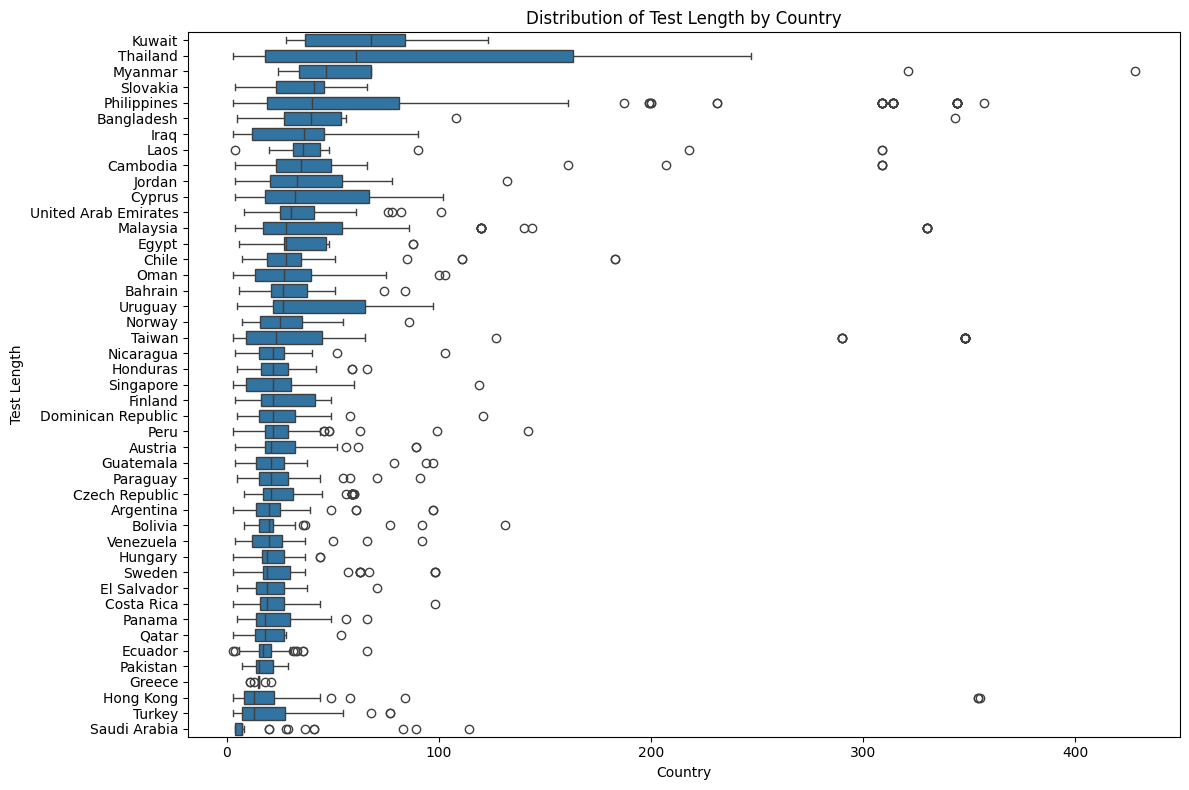

2024-12-17 10:04:34,990 INFO:box and whisker plot created
2024-12-17 10:04:34,990 INFO:creating a bar chart...


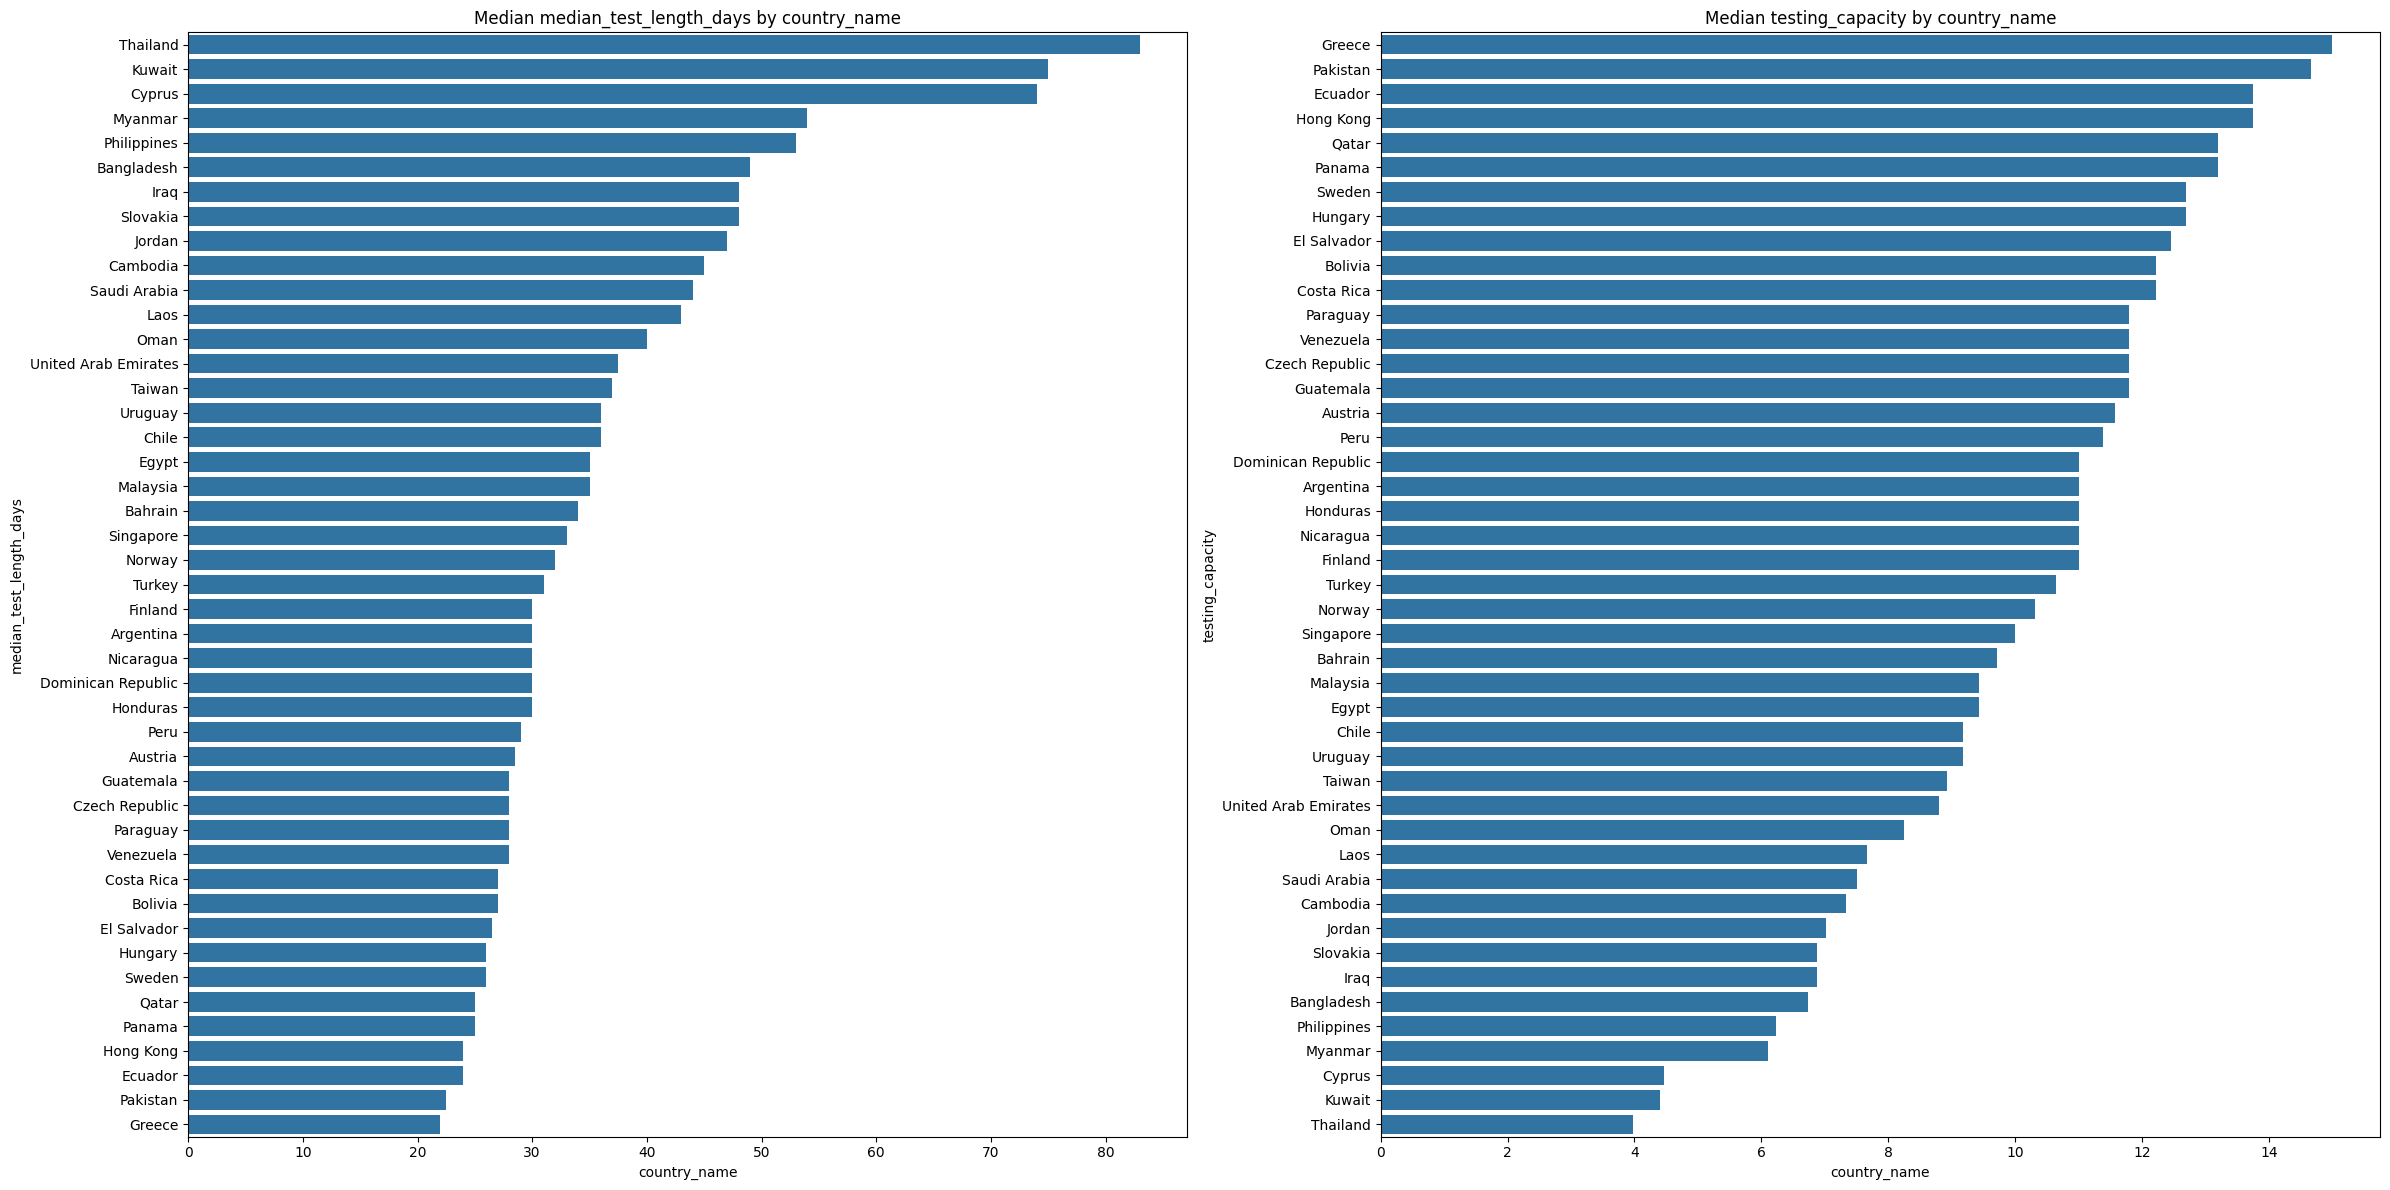

2024-12-17 10:04:35,507 INFO:bar chart created


In [121]:
if __name__ == "__main__":

    # project_id = "logistics-customer-staging"
    # logging.info(f"Initializing BigQuery client for project: {project_id}")

    # try:
    #     # Initialize BigQuery client
    #     client = bigquery.Client(project=project_id)
    # except Exception as e:
    #     logging.error(f"Failed to initialize BigQuery client: {e}")
    #     sys.exit(1)

    # # Execute queries to retrieve data
    # try:
    #     test_df = client.query(get_test_data()).to_dataframe()
    #     significance_df = client.query(get_significant_data()).to_dataframe()
    # except Exception as e:
    #     logging.error(f"Data retrieval failed: {e}")
    #     sys.exit(1) 

    # # Combine actuals data
    # try:
    #     seasonal_df = combine_actuals()
    # except Exception as e:
    #     logging.error(f"Seasonal data combination failed: {e}")
    #     sys.exit(1)

    # # Define filter type
    # filter_type = 'all'  # Options: 'all', 'significant'

    # # Apply filtering
    # try:
    #     filtered_df = get_relevant_df(filter_type, test_df, significance_df)
    #     logging.info(f"Filtered DataFrame has {len(filtered_df)} rows.")
    #     replace_values(filtered_df)
    #     logging.info(f"value replaced")
    # except ValueError as e:
    #     logging.error(e)
    #     sys.exit(1)


    # Call the create_duration_df function
    try:
        logging.info("Creating duration DataFrame...")
        duration_df = create_duration_df(filtered_df, days_slack=7, total_days=330)
        logging.info(f"Duration DataFrame created with {len(duration_df)} rows.")
    except Exception as e:
        logging.error(f"Failed to create duration DataFrame: {e}")
        sys.exit(1)

    try:
        logging.info(f"creating a box and whisker plot...")
        visual_tld_country(filtered_df)
        logging.info(f"box and whisker plot created")
    except Exception as e:
        logging.error(f"Failed to create the plot")
        sys.exit(1)

    try:
        logging.info(f"creating a bar chart...")
        visual_median_tl_country(duration_df, ['country_name', 'country_name'], ['median_test_length_days', 'testing_capacity'], num_cols=2)
        logging.info(f"bar chart created")
    except Exception as e:
        logging.error(f"Failed to create the plot")
        sys.exit(1)
        
